<a href="https://colab.research.google.com/github/mhmdihsn/UAS-DEEP-LEARNING/blob/main/Kelompok_8_AD_301_07_30_Open_Meteo_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

print("Imports selesai. Pastikan runtime Colab sudah GPU jika mau percepat training.")

Imports selesai. Pastikan runtime Colab sudah GPU jika mau percepat training.


In [ ]:
# Ambil data dari Open-Meteo dan konversi ke DataFrame
latitude = -6.2
longitude = 106.8
start_date = "2024-01-01"
end_date = "2024-12-31"

url = (
    f"https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={latitude}&longitude={longitude}"
    f"&start_date={start_date}&end_date={end_date}"
    f"&daily=temperature_2m_max,temperature_2m_min,temperature_2m_mean,"
    f"relative_humidity_2m_mean,pressure_msl_mean,windspeed_10m_max"
    f"&timezone=Asia%2FJakarta"
)

resp = requests.get(url)
data = resp.json()

df = pd.DataFrame({
    'date': data['daily']['time'],
    'temp_mean': data['daily']['temperature_2m_mean'],
    'humidity': data['daily']['relative_humidity_2m_mean'],
    'pressure': data['daily']['pressure_msl_mean'],
    'wind_speed': data['daily']['windspeed_10m_max']
})
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

print("Data sample:")
display(df.head())
print("\nData length:", len(df))


Data sample:


,temp_mean,humidity,pressure,wind_speed
date,,,,
2024-01-01,26.9,87,1009.9,10.9
2024-01-02,27.5,84,1009.0,10.2
2024-01-03,25.7,92,1009.6,8.1
2024-01-04,25.3,92,1010.3,14.1
2024-01-05,26.7,84,1010.4,11.4



Data length: 366


In [ ]:
#Feature extraction (lag, rolling, changes, seasonal, dow)
df_fe = df.copy()

# Lag features
df_fe['temp_lag1'] = df_fe['temp_mean'].shift(1)
df_fe['temp_lag2'] = df_fe['temp_mean'].shift(2)
df_fe['temp_lag3'] = df_fe['temp_mean'].shift(3)

# Rolling means and std
df_fe['temp_ma3'] = df_fe['temp_mean'].rolling(window=3).mean()
df_fe['temp_ma7'] = df_fe['temp_mean'].rolling(window=7).mean()
df_fe['temp_std3'] = df_fe['temp_mean'].rolling(window=3).std()
df_fe['temp_std7'] = df_fe['temp_mean'].rolling(window=7).std()

# Changes / diffs
df_fe['temp_change'] = df_fe['temp_mean'].diff()
df_fe['humidity_change'] = df_fe['humidity'].diff()
df_fe['pressure_change'] = df_fe['pressure'].diff()

# Seasonal (day of year) and day-of-week cyclic
df_fe['day_sin'] = np.sin(2 * np.pi * df_fe.index.dayofyear / 365)
df_fe['day_cos'] = np.cos(2 * np.pi * df_fe.index.dayofyear / 365)
df_fe['dow_sin'] = np.sin(2 * np.pi * df_fe.index.dayofweek / 7)
df_fe['dow_cos'] = np.cos(2 * np.pi * df_fe.index.dayofweek / 7)

# Drop rows with NaN resulted from shifting/rolling
df_fe.dropna(inplace=True)

print("Data setelah feature extraction (sample):")
display(df_fe.head())
print("\nBaris tersisa:", len(df_fe))


Data setelah feature extraction (sample):


,temp_mean,humidity,pressure,wind_speed,temp_lag1,temp_lag2,temp_lag3,temp_ma3,temp_ma7,temp_std3,temp_std7,temp_change,humidity_change,pressure_change,day_sin,day_cos,dow_sin,dow_cos
date,,,,,,,,,,,,,,,,,,
2024-01-07,25.9,90,1010.6,11.6,26.7,26.7,25.3,26.433333,26.385714,0.461880,0.773366,-0.8,4.0,0.6,0.120208,0.992749,-0.781831,0.623490
2024-01-08,26.4,89,1010.4,9.8,25.9,26.7,26.7,26.333333,26.314286,0.404145,0.740335,0.5,-1.0,-0.2,0.137279,0.990532,0.000000,1.000000
2024-01-09,27.3,84,1009.1,8.9,26.4,25.9,26.7,26.533333,26.285714,0.709460,0.689030,0.9,-5.0,-1.3,0.154309,0.988023,0.781831,0.623490
2024-01-10,26.9,87,1008.8,10.9,27.3,26.4,25.9,26.866667,26.457143,0.450925,0.667975,-0.4,3.0,-0.3,0.171293,0.985220,0.974928,-0.222521
2024-01-11,26.9,86,1009.3,13.4,26.9,27.3,26.4,27.033333,26.685714,0.230940,0.441318,0.0,-1.0,0.5,0.188227,0.982126,0.433884,-0.900969



Baris tersisa: 360


In [ ]:
# Fitur dan Scaling
features = [
    'temp_mean', 'humidity', 'pressure', 'wind_speed',
    'temp_lag1', 'temp_lag2', 'temp_lag3',
    'temp_ma3', 'temp_ma7', 'temp_std3', 'temp_std7',
    'temp_change', 'humidity_change', 'pressure_change',
    'day_sin', 'day_cos', 'dow_sin', 'dow_cos'
]

X_all = df_fe[features].values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_all)

print("Scaling selesai. Contoh setelah scaling (baris pertama):")
print(X_scaled[0])


Scaling selesai. Contoh setelah scaling (baris pertama):
[0.17021277 0.88571429 0.60869565 0.33009709 0.34042553 0.34042553
 0.04255319 0.1637931  0.08715596 0.24854791 0.45775825 0.2244898
 0.65517241 0.71428571 0.56010458 0.99637429 0.09903113 0.80193774]


In [ ]:
# Sequence dataset
def create_dataset(dataset, look_back=5):
    X, y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:i+look_back])
        y.append(dataset[i+look_back, 0])  # target: temp_mean (kolom 0)
    return np.array(X), np.array(y)

look_back = 5
X, y = create_dataset(X_scaled, look_back)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Shapes:")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)


Shapes:
X_train: (284, 5, 18)
X_test : (71, 5, 18)
y_train: (284,)
y_test : (71,)


In [ ]:
# LSTM model dan training
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)

# Simpan history di variable untuk plotting nanti
print("Training selesai.")


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.2895 - val_loss: 0.0454
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0578 - val_loss: 0.0471
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0343 - val_loss: 0.0539
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0340 - val_loss: 0.0418
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0223 - val_loss: 0.0406
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0233 - val_loss: 0.0396
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0216 - val_loss: 0.0391
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0226 - val_loss: 0.0388
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0222 - val_loss: 0.0384
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0188 - val_loss: 0.0377
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0200 - val_loss: 0.0372
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0190 - val_loss: 0.0367
Epoch 13/50


In [ ]:
# Evaluasi
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R2  : {r2:.4f}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
RMSE: 0.1605
R2  : 0.4492


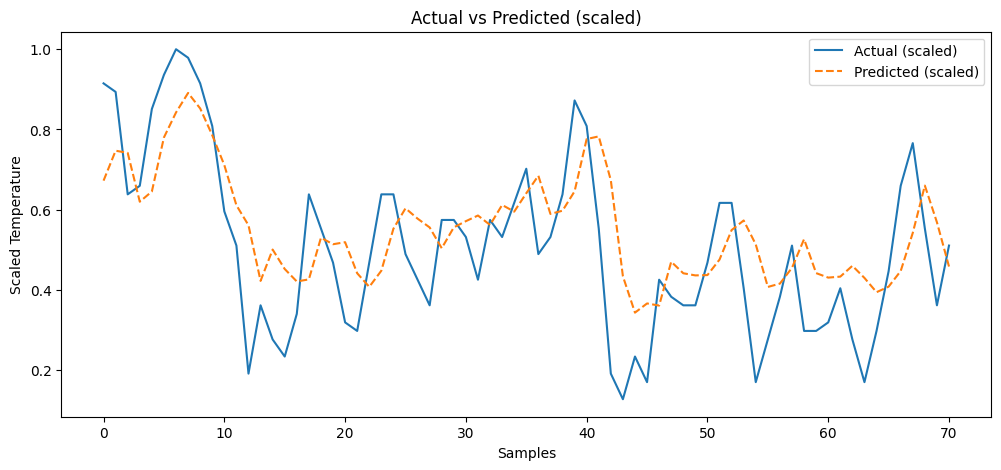

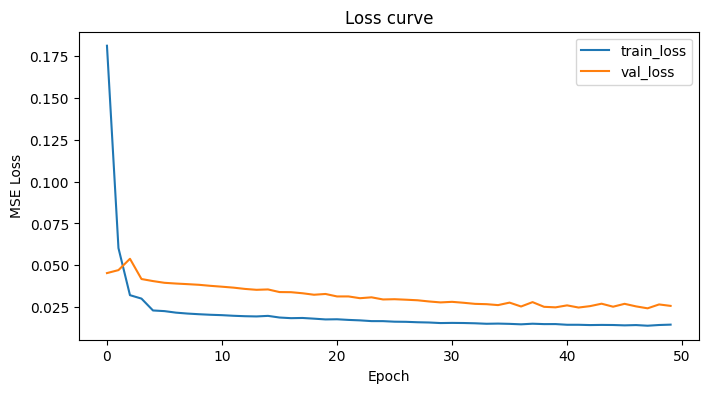

In [ ]:
# Visualisasi: actual vs pred & loss curve
import matplotlib.pyplot as plt

# 1) Actual vs Pred (scaled values)
plt.figure(figsize=(12,5))
plt.plot(y_test, label='Actual (scaled)')
plt.plot(y_pred, linestyle='--', label='Predicted (scaled)')
plt.title('Actual vs Predicted (scaled)')
plt.xlabel('Samples')
plt.ylabel('Scaled Temperature')
plt.legend()
plt.show()

# 2) Loss curve
plt.figure(figsize=(8,4))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()


RMSE (Celsius): 0.7544


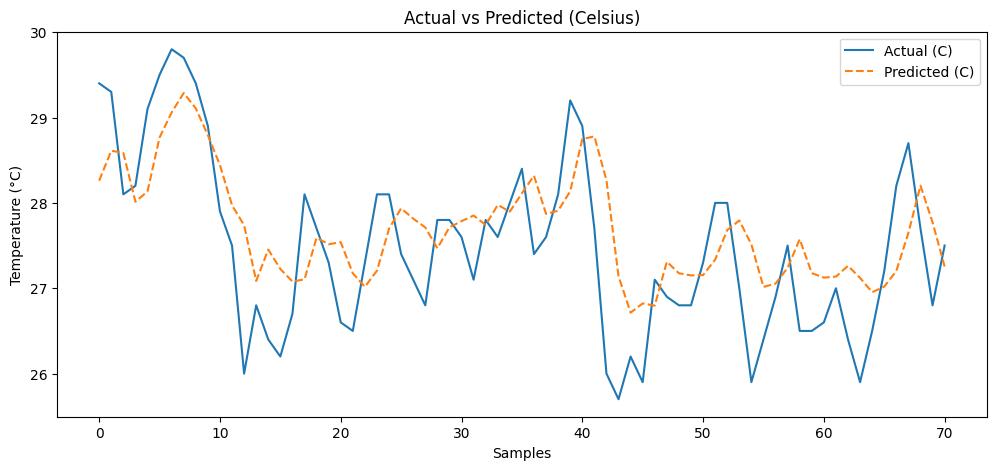

In [ ]:
# Inverse transform prediksi ke skala asli (Celsius)

def inverse_scale_targets(scaled_targets, X_reference, scaler):
    """
    scaled_targets: array shape (n,) scaled values of temp (kolom 0)
    X_reference: contoh baris fitur lengkap (n_features,) - akan direplikasi untuk membangun array
    scaler: fitted MinMaxScaler
    """
    n = len(scaled_targets)
    ref = np.tile(X_reference, (n,1))  # shape (n, n_features)
    ref[:,0] = scaled_targets  # ganti kolom 0 (temp) dengan target scaled
    inv = scaler.inverse_transform(ref)
    return inv[:,0]  # kembalikan kolom temp asli

# gunakan baris pertama X_scaled sebagai reference
ref_row = X_scaled[0]

y_test_inv = inverse_scale_targets(y_test, ref_row, scaler)
y_pred_inv = inverse_scale_targets(y_pred.flatten(), ref_row, scaler)

# Hitung RMSE asli (C)
rmse_c = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"RMSE (Celsius): {rmse_c:.4f}")

# Plot
plt.figure(figsize=(12,5))
plt.plot(y_test_inv, label='Actual (C)')
plt.plot(y_pred_inv, linestyle='--', label='Predicted (C)')
plt.title('Actual vs Predicted (Celsius)')
plt.xlabel('Samples')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()


In [ ]:
np.savez("openmeteo_preprocessed.npz",
         X_train=X_train, y_train=y_train,
         X_test=X_test, y_test=y_test)
